<a href="https://colab.research.google.com/github/Yagwar/Sociadisticas/blob/master/alc_bog_load_JSON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import networkx as nx

import seaborn as sns
sns.set(color_codes=True)

import matplotlib.gridspec as gridspec
from scipy.cluster import hierarchy

import matplotlib as mpl
mpl.style.use('seaborn')
%matplotlib inline

In [50]:
from google.colab import drive
drive.mount('/content/gdrive')
drive_path = 'gdrive/My Drive/Freelancer/alc_bog_19/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
cuentas=["ClaudiaLopez","carlosfgalan","angelamrobledo","MiguelUribeT","angelagarzonc",
         "luchogarzon","hollmanmorris","MAndreaNieto","CelioNievesH","jerojasrodrigue",
         "LuisErnestoGL"]
ids_cands=["137908875","64791701","165748292","163341528","325856294",
           "60161414","87266285","999594384","240409671","233001872",
           "2499219806"]

# Loader

In [0]:
#get users and mentions from the download files:
tweets_datas_path = [drive_path+"candidatos_alcaldia_0.json",
                     drive_path+"candidatos_alcaldia_1.json"]
tw_id=[]
tw_user_id=[]
tw_user=[]
tw_text=[]
entities_long=[]
mentioned_ids=[]
tw_device=[]# print(twits[rnd_ind]["source"])
tw_date=[]# print(twits[rnd_ind]["created_at"])


for json_file in tweets_datas_path:
    with open(json_file, "r") as tweets_file:
        for line in tweets_file:
            try:
                tweet = json.loads(line)
                tw_entities=[]
                tw_entities.extend(tweet["entities"]["user_mentions"])
                entities_long.extend(tweet["entities"]["user_mentions"])
                tw_text_loop=[tweet["text"]]
                if tweet["truncated"]:#=="True": # Truncated indica si el tweet es corto o largo; si truncado, busca extendido
                    tw_text_loop=[tweet["extended_tweet"]["full_text"]]
                    tw_entities.extend(tweet["extended_tweet"]["entities"]["user_mentions"])
                    entities_long.extend(tweet["extended_tweet"]["entities"]["user_mentions"])
                else:
                    if tweet["text"][0:2]=="RT":
                        if tweet["retweeted_status"]["truncated"]:
                            tw_text_loop=[tweet["retweeted_status"]["extended_tweet"]["full_text"]]
                            tw_entities.extend(tweet["retweeted_status"]["extended_tweet"]["entities"]["user_mentions"])
                            entities_long.extend(tweet["retweeted_status"]["extended_tweet"]["entities"]["user_mentions"])
                        else: 
                            tw_text_loop=[tweet["retweeted_status"]["text"]]
                            tw_entities.extend(tweet["retweeted_status"]["entities"]["user_mentions"])
                        if tweet["retweeted_status"]["is_quote_status"]:
                            tw_text_loop=[tweet["retweeted_status"]["extended_tweet"]["full_text"]]
                            tw_entities.extend(tweet["retweeted_status"]["quoted_status"]["entities"]["user_mentions"])
                            entities_long.extend(tweet["retweeted_status"]["quoted_status"]["entities"]["user_mentions"])
                    else:
                        tw_text_loop=[tweet["text"]]
                tw_id.append(tweet["id_str"])
                tw_user_id.append(tweet["user"]["id_str"])
                tw_user.append(tweet["user"]["screen_name"])
                mentioned_ids.append([tweet["id_str"],tweet["user"]["id_str"],list(set([ent["id_str"] for ent in tw_entities]))])
                tw_text.append([tweet["id_str"],tw_text_loop[0]])
                tw_device.append(tweet["source"])
                tw_date.append(tweet["created_at"])
            except:
                continue

In [53]:
print("Tweets identificados con código     :",len(tw_id),"\n",
      "Tweets con usuario identificado     :",len(tw_user_id),"\n",
      "Tweets con nombre de usuario        :",len(tw_user),"\n",
      "Textos de tweets recuperados        :",len(tw_text),"\n",
      "Total de Menciones en los tweets    :",len(entities_long),"\n",
      "Tweets con menciones identificadas  :",len(mentioned_ids),"\n",
      "Tweets con dispositivos registrado  :",len(tw_device),"\n",
      "Tweets con fechas registradas       :",len(tw_date),"\n"
     )

Tweets identificados con código     : 326319 
 Tweets con usuario identificado     : 326319 
 Tweets con nombre de usuario        : 326319 
 Textos de tweets recuperados        : 326319 
 Total de Menciones en los tweets    : 1914483 
 Tweets con menciones identificadas  : 326319 
 Tweets con dispositivos registrado  : 326319 
 Tweets con fechas registradas       : 326319 



In [0]:
tw_device=[dvc[dvc.find(">")+1:dvc.find("<",2)] for dvc in tw_device]
tw_text=np.array(tw_text)

### Tabla de menciones

In [0]:
ments_df=pd.DataFrame([[entit["id_str"],
                        entit["screen_name"],
                        entit["name"]
                       ]for entit in entities_long],
                     columns=["id_str","screen_name","name"])

In [56]:
ments_freq=pd.crosstab(index=ments_df.screen_name, columns="count")
ments_freq=ments_freq.sort_values(by=['count'] , ascending=False)
print("Cuentas mencionadas",ments_freq.shape[0])

Cuentas mencionadas 22832


In [0]:
# Tabla de ocurrencia de menciones por tuit
id_ments=pd.crosstab(np.array([tw_mnt for tw_mntns in mentioned_ids for tw_mnt in tw_mntns[2] ]), columns="count").sort_values(ascending=False, by="count")
# se utiliza el código para evitar conteos por homónimos

In [58]:
id_ments.head()


col_0,count
row_0,
137908875,160117
165748292,54358
49849732,53592
163341528,47494
87266285,39585


In [0]:
top_n=150


In [0]:
ments_ids_top=list(id_ments.index[:top_n])

In [0]:
mntns_top_ocurr=np.array([[cand in tw_mntns[2] for cand in ments_ids_top]for tw_mntns in mentioned_ids])
mntns_candts=np.array([[cand in tw_mntns[2] for cand in ids_cands]for tw_mntns in mentioned_ids])

In [97]:
print(mntns_top_ocurr.shape)
print(mntns_candts.shape)

(326319, 150)
(326319, 11)


In [0]:
names_mnts_top=[]
for usr_id in id_ments.index[:top_n]:
    name=""
    try:
        name=ments_df[ments_df.id_str==usr_id].screen_name.iloc[0]
    except:
        name="Unknown"
#     print(usr_id, name)
    names_mnts_top.append(name)
        
#     print(usr_id,tweets_ids[tweets_ids.tw_user_id==usr_id].tw_user.iloc[0])

In [0]:
# twtxt_ids=[txt_id[0] for txt_id in tw_text] # Id del tuit con el texto
df_mntns_top_ocurr=pd.DataFrame(mntns_top_ocurr,columns=names_mnts_top, index=tw_id)
df_mntns_candts=pd.DataFrame(mntns_candts,columns=cuentas, index=tw_id)

In [116]:
print(df_mntns_top_ocurr.shape)
print(df_mntns_candts.shape)

(326319, 150)
(326319, 11)


In [117]:
tweets_ids=pd.DataFrame({"tw_user_id":tw_user_id,"tw_user":tw_user}, index=tw_id)
ids_freqs=pd.crosstab(index=tweets_ids.tw_user, columns="count")
ids_freqs=ids_freqs.sort_values(by=['count'] , ascending=False)["count"]
print("twiteros:",ids_freqs.shape[0])

twiteros: 59952


row_0
Twitter for Android    200947
Twitter for iPhone      70890
Twitter Web App         25422
Twitter Web Client      22965
Twitter for iPad         4557
TweetDeck                 597
Pypbot                    486
Mobile Web (M2)           150
Facebook                   36
Paper.li                   30
Name: count, dtype: int64

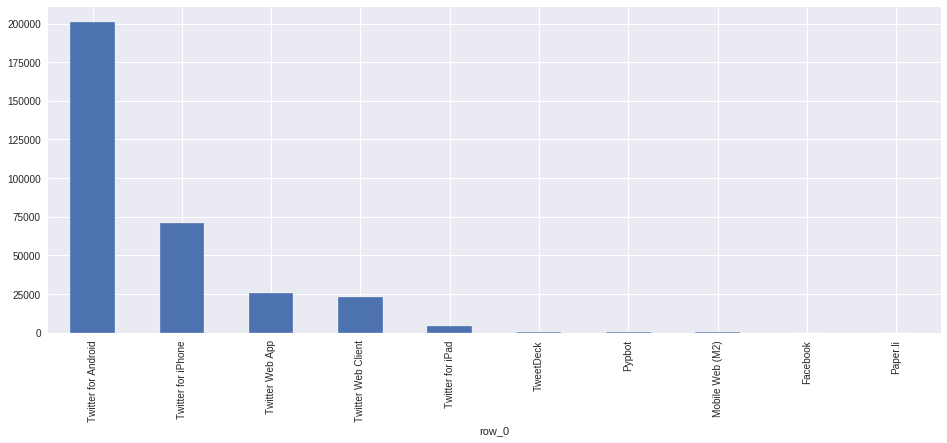

In [118]:
devices=pd.crosstab(index=np.array(tw_device), columns="count")
devices=devices.sort_values(by=['count'] , ascending=False)["count"]
devices[:10].plot(figsize=(16, 6), kind="bar")
devices[:10]

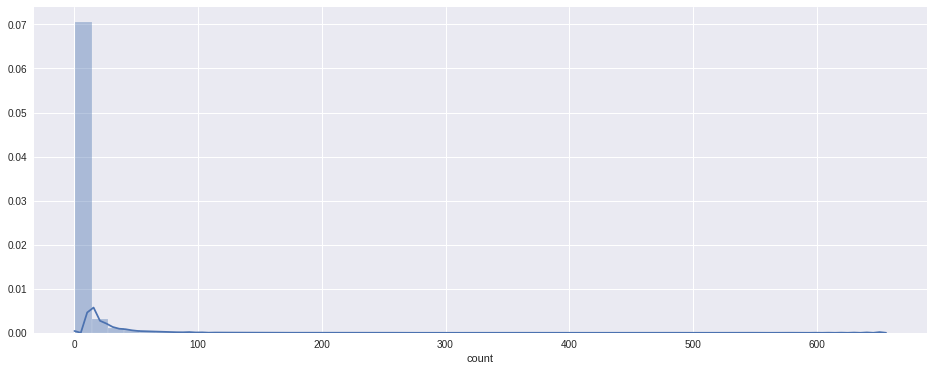

In [71]:
plt.figure(figsize=(16,6))
sns.distplot(ids_freqs)

In [72]:
round(ids_freqs.describe(),3)

count    59952.000
mean         5.443
std         14.575
min          1.000
25%          1.000
50%          2.000
75%          4.000
max        655.000
Name: count, dtype: float64

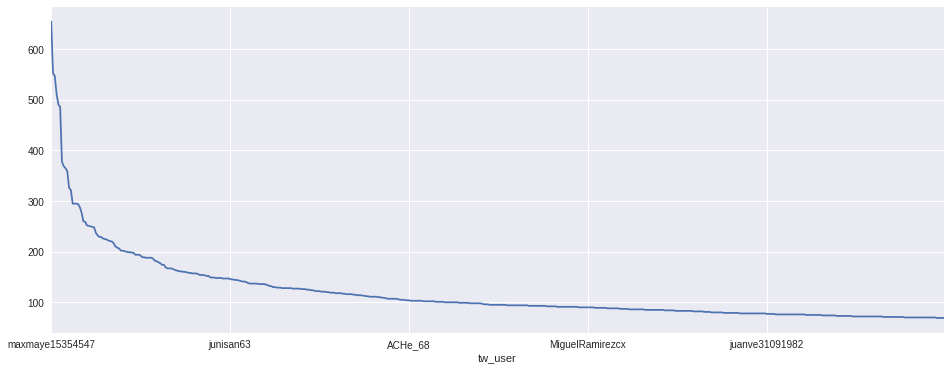

In [73]:
ids_freqs[:500].plot(figsize=(16, 6))

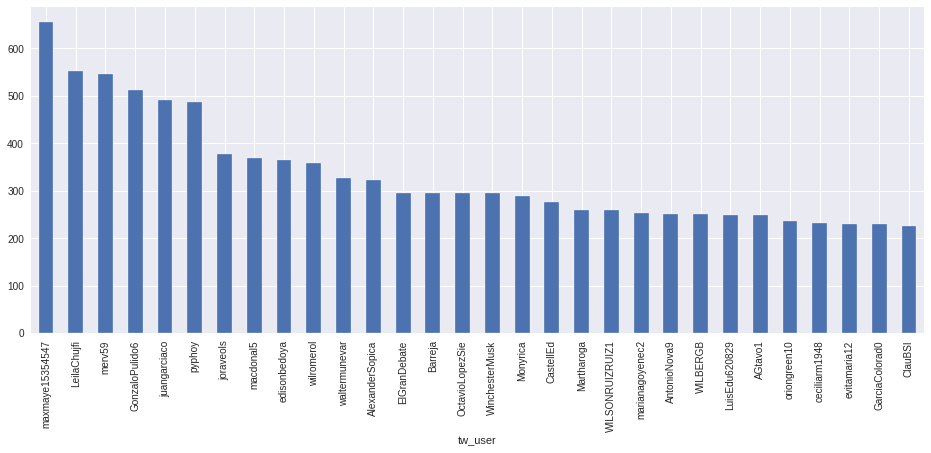

In [136]:
ids_freqs[:30].plot(figsize=(16, 6), kind="bar")
plt.savefig(drive_path+'top_tweeters.png')

In [109]:
ids_freqs.sort_values(ascending=False)[:60]

tw_user
maxmaye15354547    655
LeilaChujfi        553
merv59             547
GonzaloPulido6     512
juangarciaco       491
pyphoy             486
joraveols          378
macdonal5          369
edisonbedoya       365
wilromerol         359
waltermunevar      326
AlexanderSopica    322
OctavioLopezSie    295
Barreja            295
ElGranDebate       295
WinchesterMusk     294
Monyrica           288
CastellEd          277
Martharoga         260
WILSONRUIZRUIZ1    259
marianagoyenec2    252
AntonioNova9       251
WILBERGB           250
LuisEdu620829      249
AGtavo1            248
oriongreen10       237
ceciliarm1948      232
GarciaColorad0     229
evitamaria12       229
ClauBSI            226
pbandido1          225
neoflash5          224
helmanzano         222
YehiniCarolina     221
marco_caldono      220
LaPazColombiani    216
ledamejia21        210
BOGOTASINMIEDO     208
rmogollon55        206
CarlosCarrilloA    202
AmparoOrtegab      202
HellennDeTroya     201
pizarro2019        200
Kik

In [110]:
uniq_ids=list(set([entit["id_str"]for entit in entities_long]))
len(uniq_ids)

22755

ClaudiaLopez       160117
angelamrobledo      54358
petrogustavo        53592
MiguelUribeT        47494
HOLLMANMORRIS       39585
GustavoBolivar      24289
EnriquePenalosa     21994
angelagarzonc       18116
carlosfgalan        17836
IvanDuque           16340
LuisErnestoGL       15987
jerojasrodrigue     15795
CConstitucional     12884
PizarroMariaJo      11696
GNavasTalero        11657
CarlosCarrilloA     11622
AidaAvellaE         11498
DavidRacero         10298
AngelicaLozanoC     10228
IvanCepedaCast       9552
dtype: int64


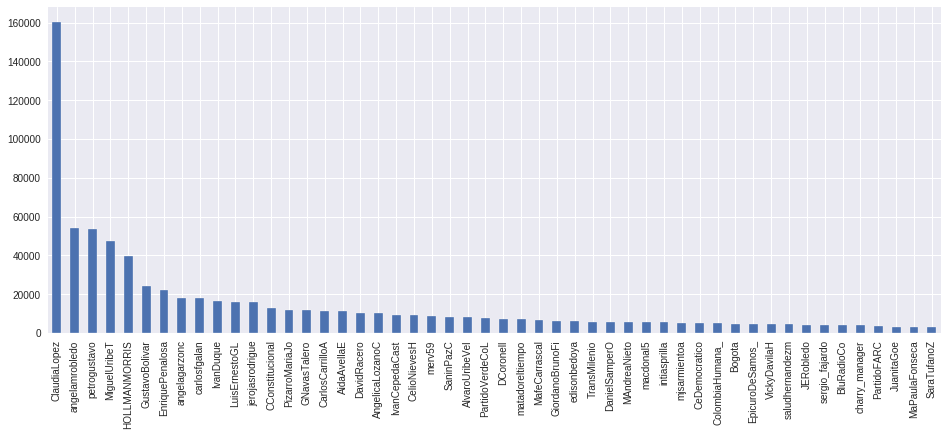

In [137]:
plt.figure(figsize=(16,6))
print (df_mntns_top_ocurr.sum(axis=0).sort_values(ascending=False)[:20])
df_mntns_top_ocurr.sum(axis=0).sort_values(ascending=False)[:50].plot(kind="bar")
plt.savefig(drive_path+'top_mentions.png')

ClaudiaLopez       160117
angelamrobledo      54358
MiguelUribeT        47494
hollmanmorris       39585
angelagarzonc       18116
carlosfgalan        17836
LuisErnestoGL       15987
jerojasrodrigue     15795
CelioNievesH         9548
MAndreaNieto         5512
luchogarzon          2147
dtype: int64


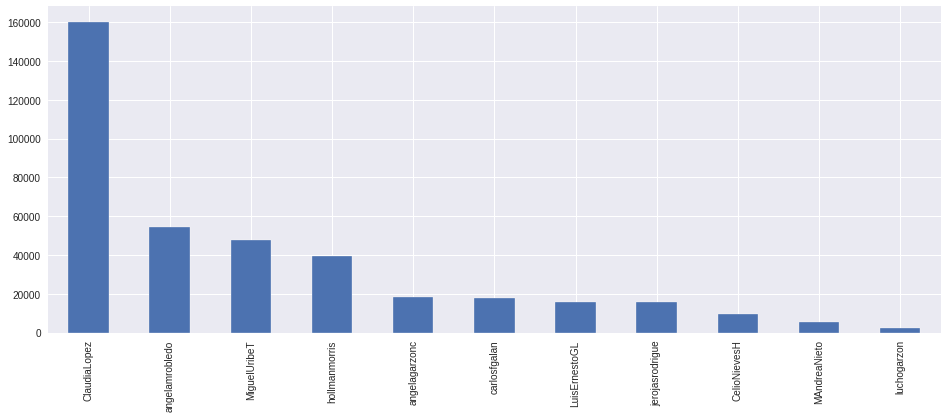

In [138]:
plt.figure(figsize=(16,6))
print (df_mntns_candts.sum(axis=0).sort_values(ascending=False)[:20])
df_mntns_candts.sum(axis=0).sort_values(ascending=False)[:50].plot(kind="bar")
plt.savefig(drive_path+'df_mntns_candts.png')

# Relaciones de cuentas

In [0]:
directed_graph_df=df_mntns_top_ocurr.groupby(tw_user).aggregate(sum)
mat_dendr=directed_graph_df.loc[directed_graph_df.sum(axis=1).sort_values(ascending=False)[:500].index,:]
# mat_dendr.sample(20)

In [0]:
ments_ward= hierarchy.linkage(mat_dendr.transpose(), 'ward')

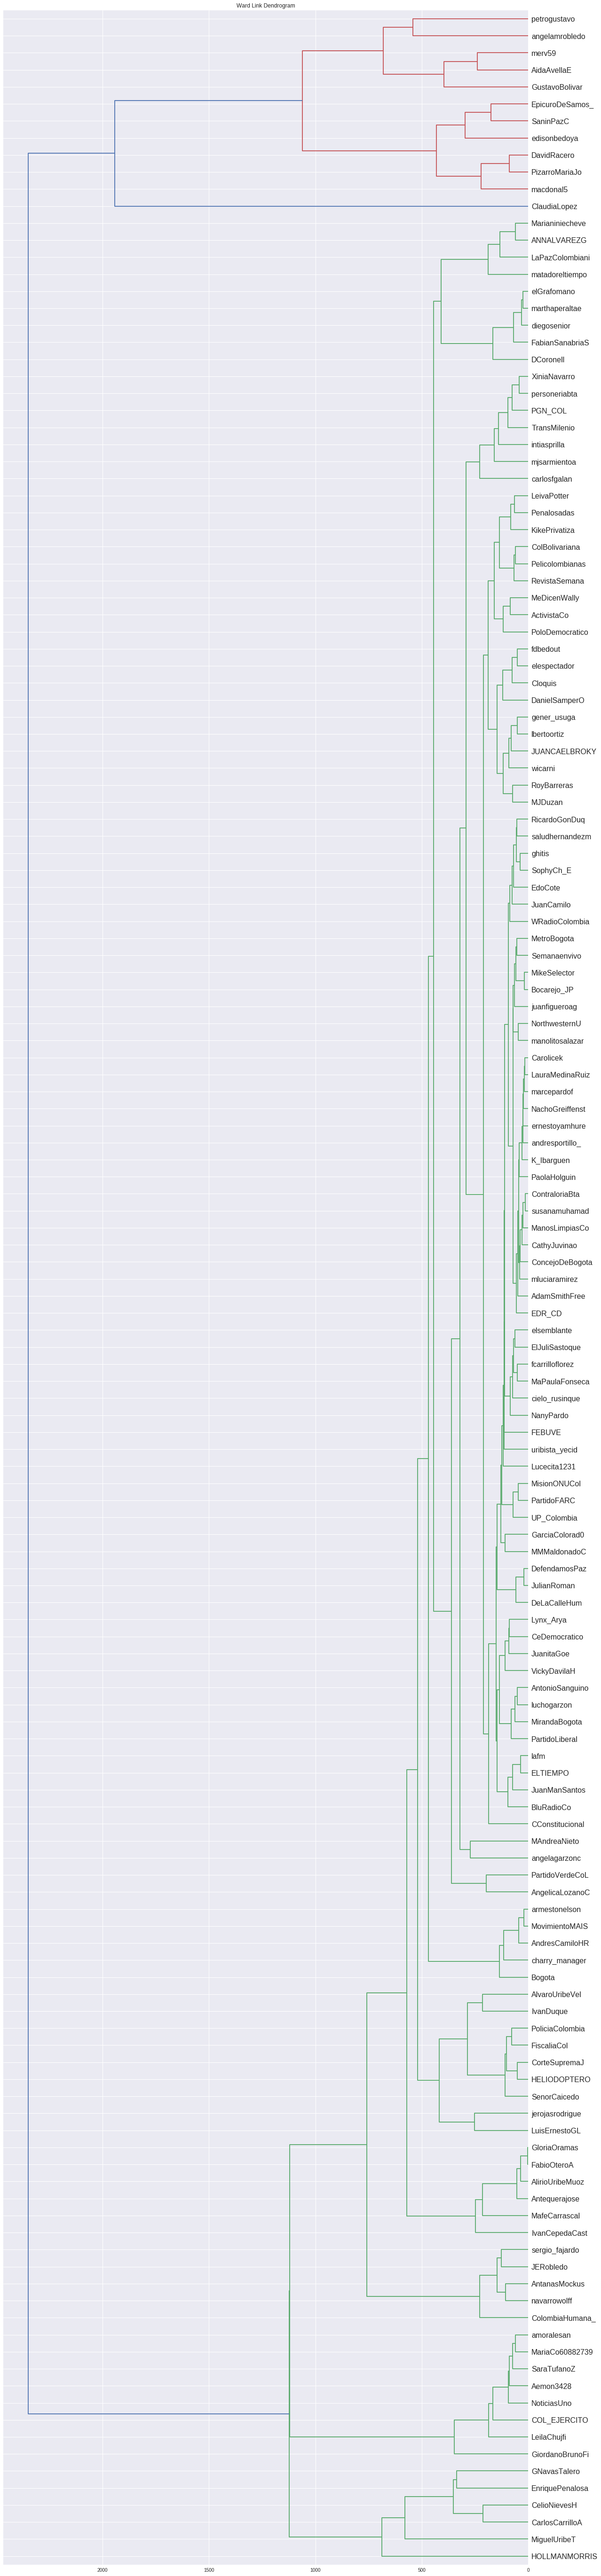

In [139]:
plt.figure(figsize=(20,100))
dn = hierarchy.dendrogram(ments_ward,orientation="left", labels=df_mntns_top_ocurr.sum(axis=0).sort_values(ascending=False).index)
plt.yticks(fontsize=16)
plt.title('Ward Link Dendrogram')
plt.savefig(drive_path+'ments_dendrograma_ward.png')
plt.show()

In [0]:
directed_graph_df_candts=df_mntns_candts.groupby(tw_user).aggregate(sum)
mat_dendr_candts=directed_graph_df_candts.loc[directed_graph_df_candts.sum(axis=1).sort_values(ascending=False)[:500].index,:]
# mat_dendr_candts.sample(20)

In [0]:
cands_ward= hierarchy.linkage(mat_dendr_candts.transpose(), 'ward')

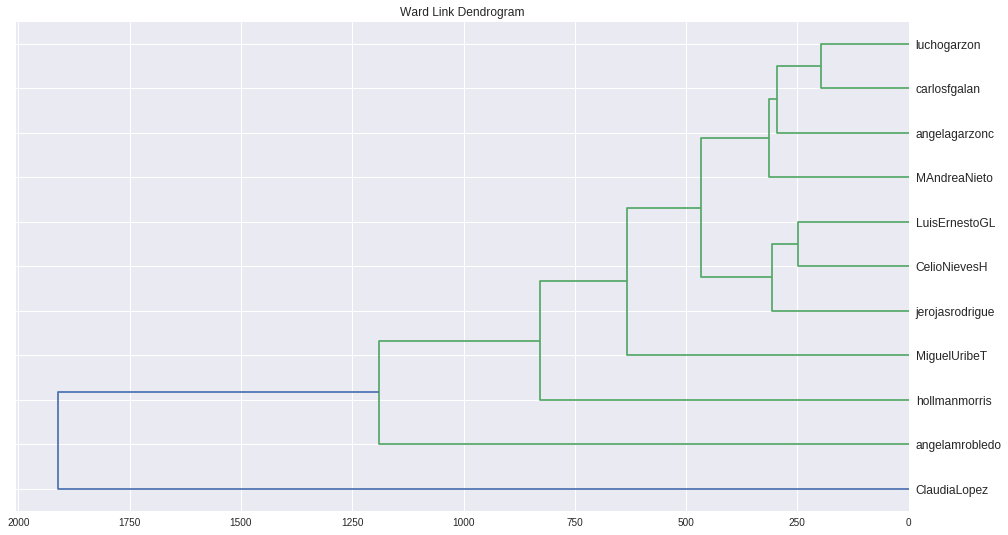

In [145]:
plt.figure(figsize=(16,9))
dn = hierarchy.dendrogram(cands_ward,orientation="left", labels=cuentas)
# plt.yticks(fontsize=16)
plt.title('Ward Link Dendrogram')
plt.savefig(drive_path+'cands_dendrograma_ward.png')
plt.show()

# Temporalidad

In [0]:
tw_fechas_df=pd.DataFrame(np.column_stack([tw_user,tw_date]))
tw_fechas_df.columns=["user","date_tweet"]
tw_fechas_df["date_tweet"]=pd.to_datetime(tw_fechas_df['date_tweet'], utc=True)#.tz_convert('US/Eastern')
tw_fechas_df.set_index('date_tweet', inplace=True)#.tz_convert('US/Eastern')
tw_fechas_df.index=tw_fechas_df.index.tz_convert('Etc/GMT+5')
tw_fechas_df["ocurr"]=1

In [0]:
time_sample="900S"#"3600s"#'1440T'

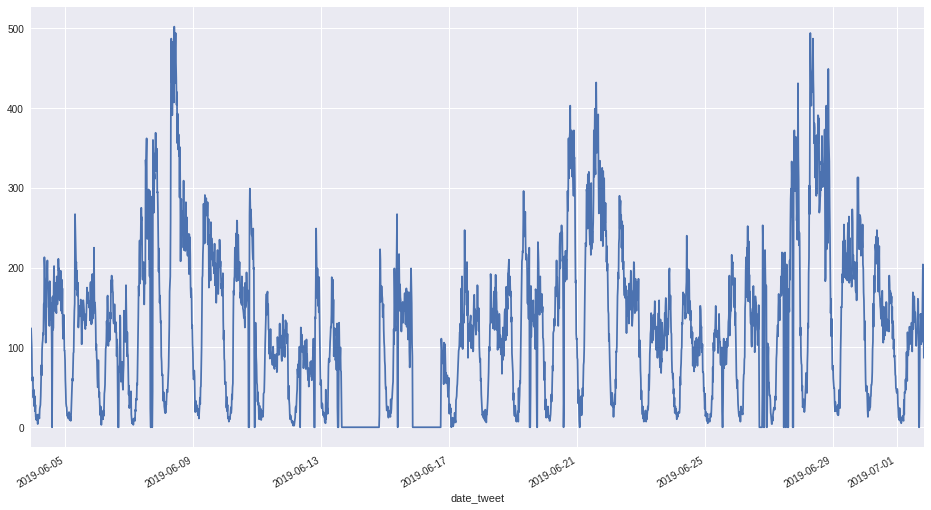

In [148]:
plt.figure(figsize=(16,9))
tw_fechas_df.ocurr.resample(time_sample).sum().plot()#kind="bar")

## Menciones

In [0]:
mayor_tweeters=list(directed_graph_df.sum(axis=1).sort_values(ascending=False).index[:10])

In [0]:
tw_fechas_df_top=tw_fechas_df[tw_fechas_df.user.isin(mayor_tweeters)]

In [0]:
twits_filt=pd.crosstab(index=tw_fechas_df_top.index,
                  columns=tw_fechas_df_top["user"])
twits_filt=twits_filt.resample(time_sample).sum()

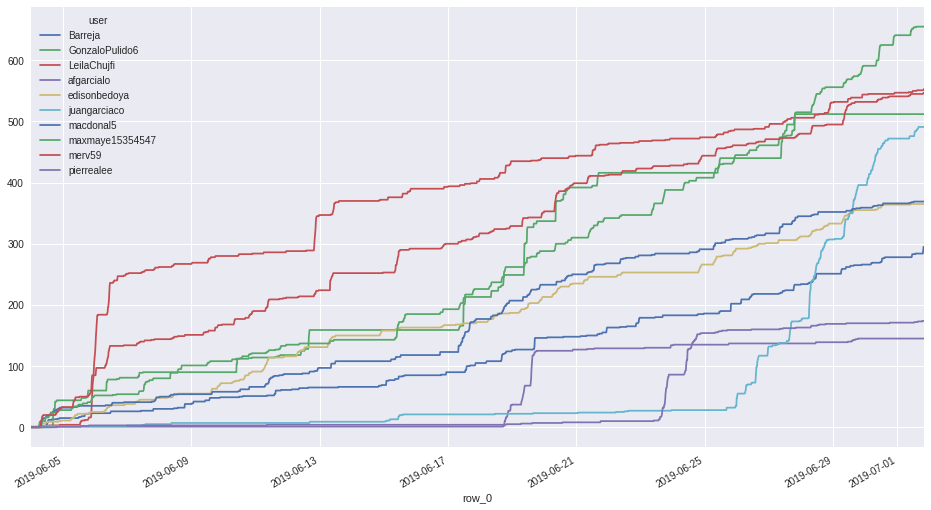

In [152]:
twits_filt.cumsum().plot(figsize=(16,9))

In [0]:
top_ments_df=df_mntns_top_ocurr.copy()*1
top_ments_df.index=tw_fechas_df.index
# top_ments_df.head(20)

In [0]:
top_ments_df_day=top_ments_df.iloc[:,:10].resample(time_sample).sum()

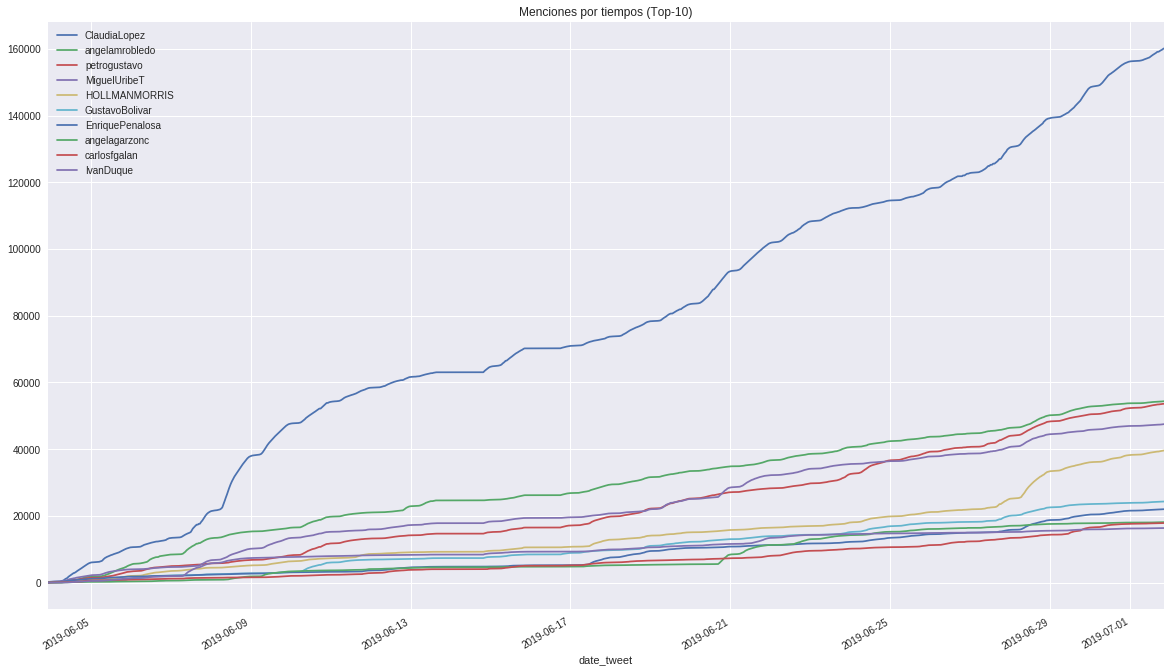

In [170]:
top_ments_df_day.cumsum().plot(figsize=(20,12), title="Menciones por tiempos (Top-10)")

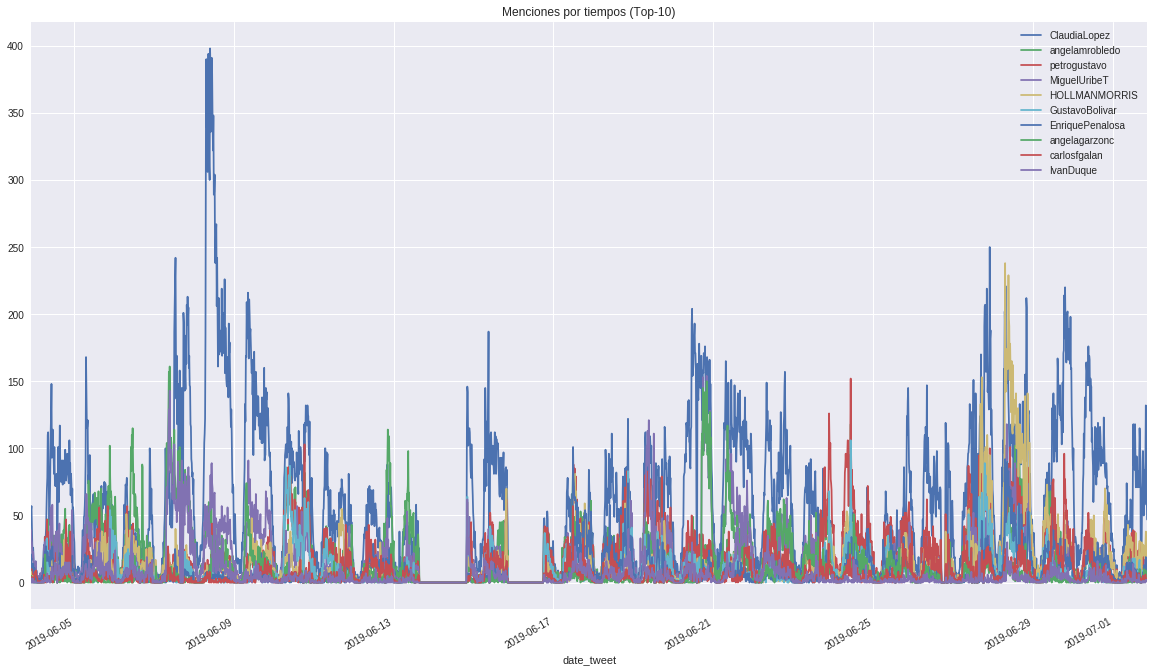

In [156]:
top_ments_df_day.plot(figsize=(20,12), title="Menciones por tiempos (Top-10)")

## Candidatos

In [0]:
tw_fechas_df_cands=tw_fechas_df[tw_fechas_df.user.isin(cuentas)]

In [0]:
twits_filt_cands=pd.crosstab(index=tw_fechas_df_cands.index,
                  columns=tw_fechas_df_cands["user"])
twits_filt_cands=twits_filt_cands.resample(time_sample).sum()

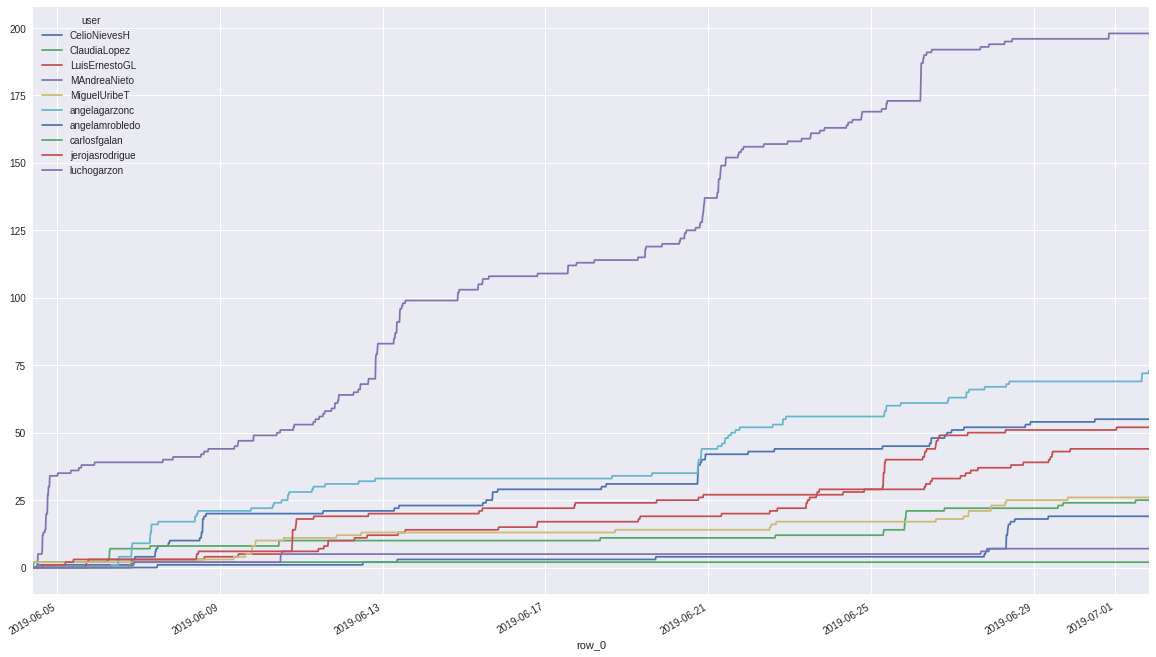

In [181]:
twits_filt_cands.cumsum().plot(figsize=(20,12))# No cuadra este gráfico # Revisar!!!!!!

# Grafos

In [182]:
mat_size=40
graph_mat=directed_graph_df.loc[directed_graph_df.sum(axis=1).sort_values(ascending=False).index[:mat_size],
                                directed_graph_df.sum(axis=0).sort_values(ascending=False).index[:mat_size]
                               ]
graph_mat.head()

,ClaudiaLopez,angelamrobledo,petrogustavo,MiguelUribeT,HOLLMANMORRIS,GustavoBolivar,EnriquePenalosa,angelagarzonc,carlosfgalan,IvanDuque,LuisErnestoGL,jerojasrodrigue,CConstitucional,PizarroMariaJo,GNavasTalero,CarlosCarrilloA,AidaAvellaE,DavidRacero,AngelicaLozanoC,IvanCepedaCast,CelioNievesH,merv59,SaninPazC,AlvaroUribeVel,PartidoVerdeCoL,DCoronell,matadoreltiempo,MafeCarrascal,GiordanoBrunoFi,edisonbedoya,TransMilenio,DanielSamperO,MAndreaNieto,macdonal5,intiasprilla,mjsarmientoa,CeDemocratico,ColombiaHumana_,Bogota,EpicuroDeSamos_
LeilaChujfi,85.0,399.0,91.0,9.0,34.0,309.0,7.0,0.0,0.0,71.0,27.0,28.0,0.0,11.0,39.0,2.0,249.0,18.0,21.0,22.0,15.0,369.0,9.0,30.0,8.0,86.0,137.0,8.0,260.0,6.0,1.0,34.0,0.0,19.0,1.0,0.0,2.0,9.0,6.0,19.0
merv59,51.0,420.0,314.0,4.0,17.0,338.0,2.0,1.0,2.0,53.0,2.0,11.0,0.0,286.0,17.0,2.0,353.0,266.0,17.0,56.0,14.0,463.0,168.0,111.0,16.0,20.0,65.0,13.0,81.0,283.0,0.0,31.0,0.0,251.0,13.0,0.0,22.0,4.0,0.0,141.0
edisonbedoya,1.0,359.0,344.0,0.0,0.0,336.0,0.0,0.0,0.0,31.0,0.0,0.0,0.0,355.0,0.0,0.0,358.0,316.0,0.0,48.0,0.0,310.0,194.0,106.0,4.0,2.0,46.0,1.0,1.0,0.0,0.0,0.0,0.0,293.0,4.0,0.0,21.0,0.0,0.0,156.0
maxmaye15354547,287.0,24.0,91.0,53.0,154.0,35.0,94.0,15.0,33.0,2.0,102.0,44.0,0.0,12.0,239.0,265.0,8.0,12.0,14.0,17.0,235.0,18.0,20.0,2.0,53.0,2.0,5.0,15.0,91.0,1.0,26.0,17.0,0.0,2.0,14.0,93.0,1.0,32.0,17.0,3.0
macdonal5,90.0,208.0,216.0,15.0,38.0,187.0,11.0,9.0,0.0,30.0,1.0,12.0,0.0,162.0,11.0,0.0,167.0,143.0,35.0,58.0,1.0,234.0,99.0,60.0,49.0,7.0,58.0,5.0,1.0,174.0,3.0,24.0,0.0,290.0,19.0,4.0,18.0,1.0,0.0,82.0


In [183]:
graph_mat.shape

(40, 40)

In [0]:
graph_df=graph_mat.melt()
graph_df.columns=["tw_para", "freq"]
graph_df["tw_de"]=[usr for i in range(int(len(graph_df)/len(graph_mat.index)))for usr in list(graph_mat.index)]
graph_df=graph_df.loc[:,["tw_de","tw_para","freq"]]

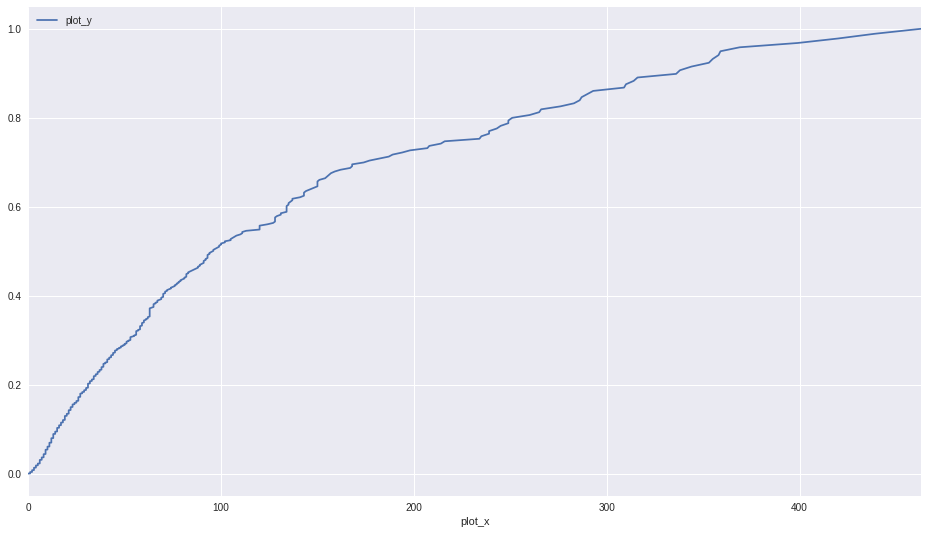

In [185]:
plot_x=np.array(list(graph_df.freq.sort_values(ascending=True)))
plot_y=np.cumsum(plot_x)/sum(plot_x)
cum_freq=pd.DataFrame({"plot_x":plot_x,
                       "plot_y":plot_y})
cum_freq.plot(x="plot_x",
              y="plot_y",
             figsize=(16,9))

In [186]:
min_crit_tw=cum_freq[cum_freq.plot_y>=.3].iloc[0,0]
graph_df_filt=graph_df.loc[graph_df.freq>=min_crit_tw,:]
mx_fr=max(graph_df_filt.freq)
print(min_crit_tw)
print(len(graph_df_filt))
graph_df_filt.sort_values("freq",ascending=False)#.head(20)

53.0
226


,tw_de,tw_para,freq
841,merv59,merv59,463.0
29,pyphoy,ClaudiaLopez,439.0
41,merv59,angelamrobledo,420.0
40,LeilaChujfi,angelamrobledo,399.0
840,LeilaChujfi,merv59,369.0
42,edisonbedoya,angelamrobledo,359.0
642,edisonbedoya,AidaAvellaE,358.0
522,edisonbedoya,PizarroMariaJo,355.0
641,merv59,AidaAvellaE,353.0
82,edisonbedoya,petrogustavo,344.0


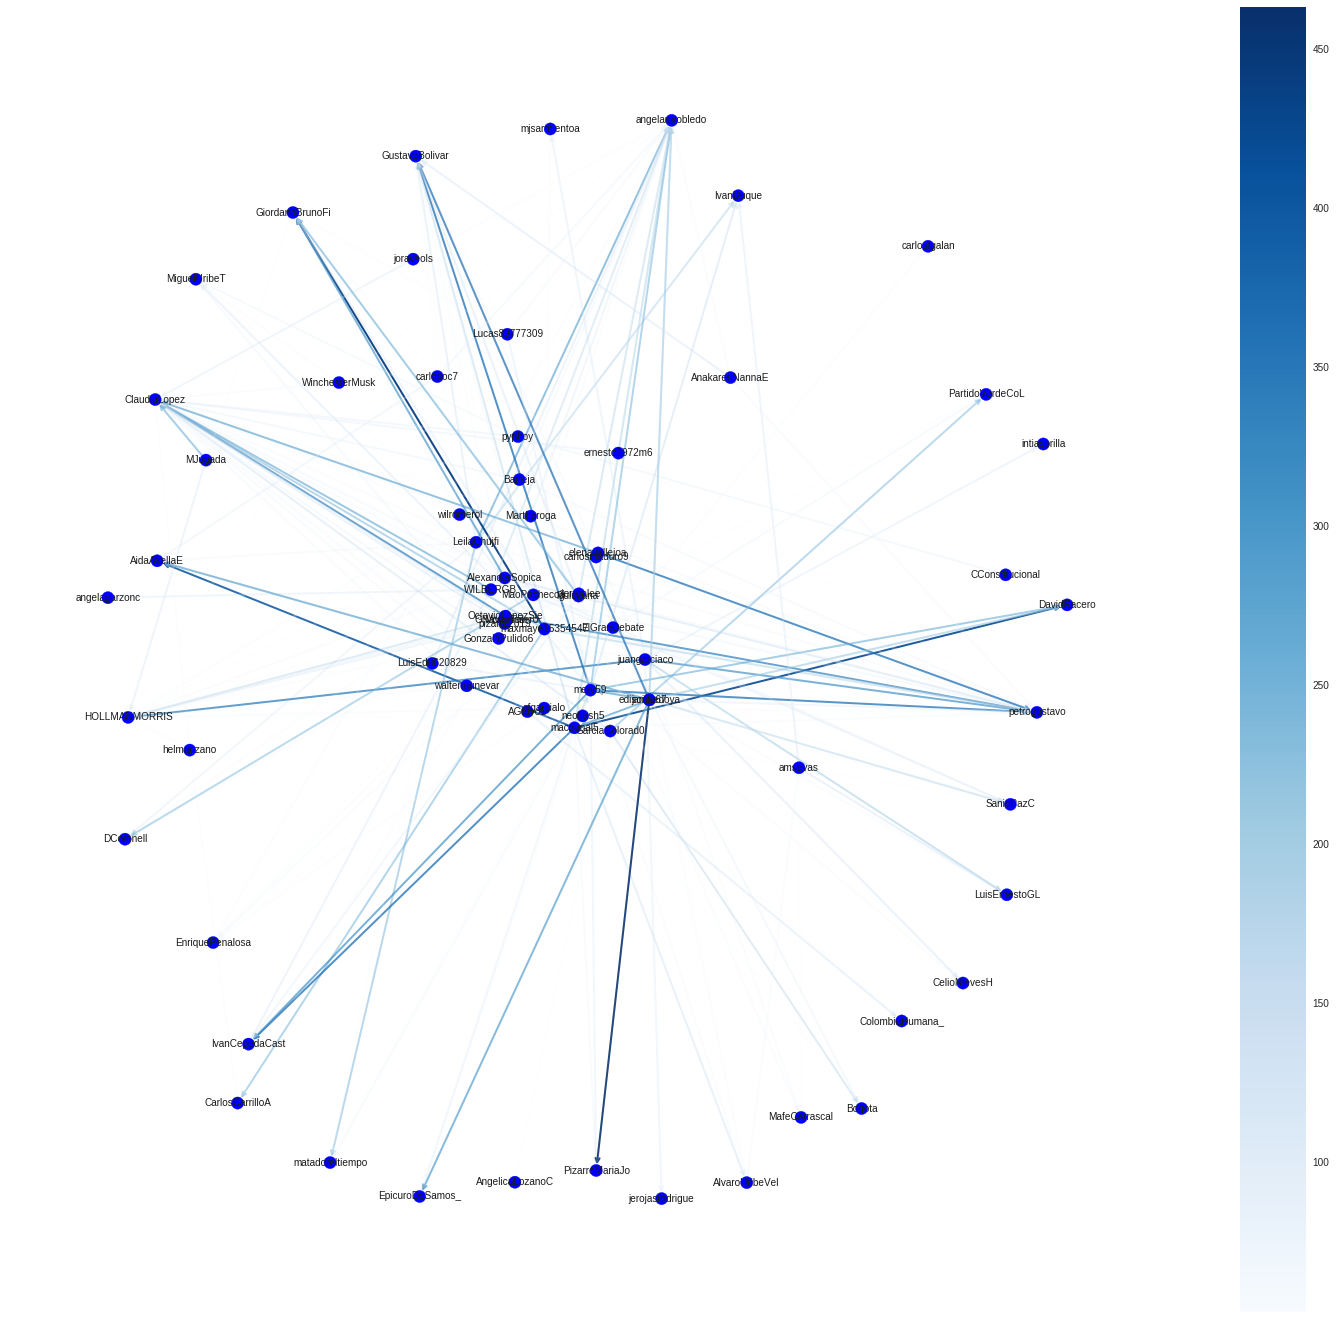

In [187]:
plt.figure(figsize=(26,24))
G= nx.DiGraph()#nx.generators.directed.random_k_out_graph(10, 3, 0.5)
for i, elrow in graph_df_filt.iterrows():
    G.add_edge(elrow[0], elrow[1])

pos = nx.layout.spring_layout(G)

node_sizes = [150 for i in range(len(G))]
M = G.number_of_edges()
edge_colors =[fr for fr in graph_df_filt.freq]#range(2, M + 2)
edge_alphas =[fr/mx_fr for fr in graph_df_filt.freq]#[fr/mx_fr for fr in graph_df_filt.freq]#[(5 + i) / (M + 4) for i in range(M)]

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='blue')
edges = nx.draw_networkx_edges(G, pos, node_size=node_sizes, arrowstyle='->',
                               arrowsize=10, edge_color=edge_colors,
                               edge_cmap=plt.cm.Blues, width=2)
# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

nx.draw_networkx_labels(G, pos, font_size=10)

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(edge_colors)
plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
plt.show()

In [0]:
g = nx.Graph()


In [0]:
for i, elrow in graph_df_filt.iterrows():
    g.add_edge(elrow[0], elrow[1], attr_dict=elrow[2:].to_dict())

In [190]:
print('# of edges: {}'.format(g.number_of_edges()))
print('# of nodes: {}'.format(g.number_of_nodes()))

# of edges: 223
# of nodes: 71


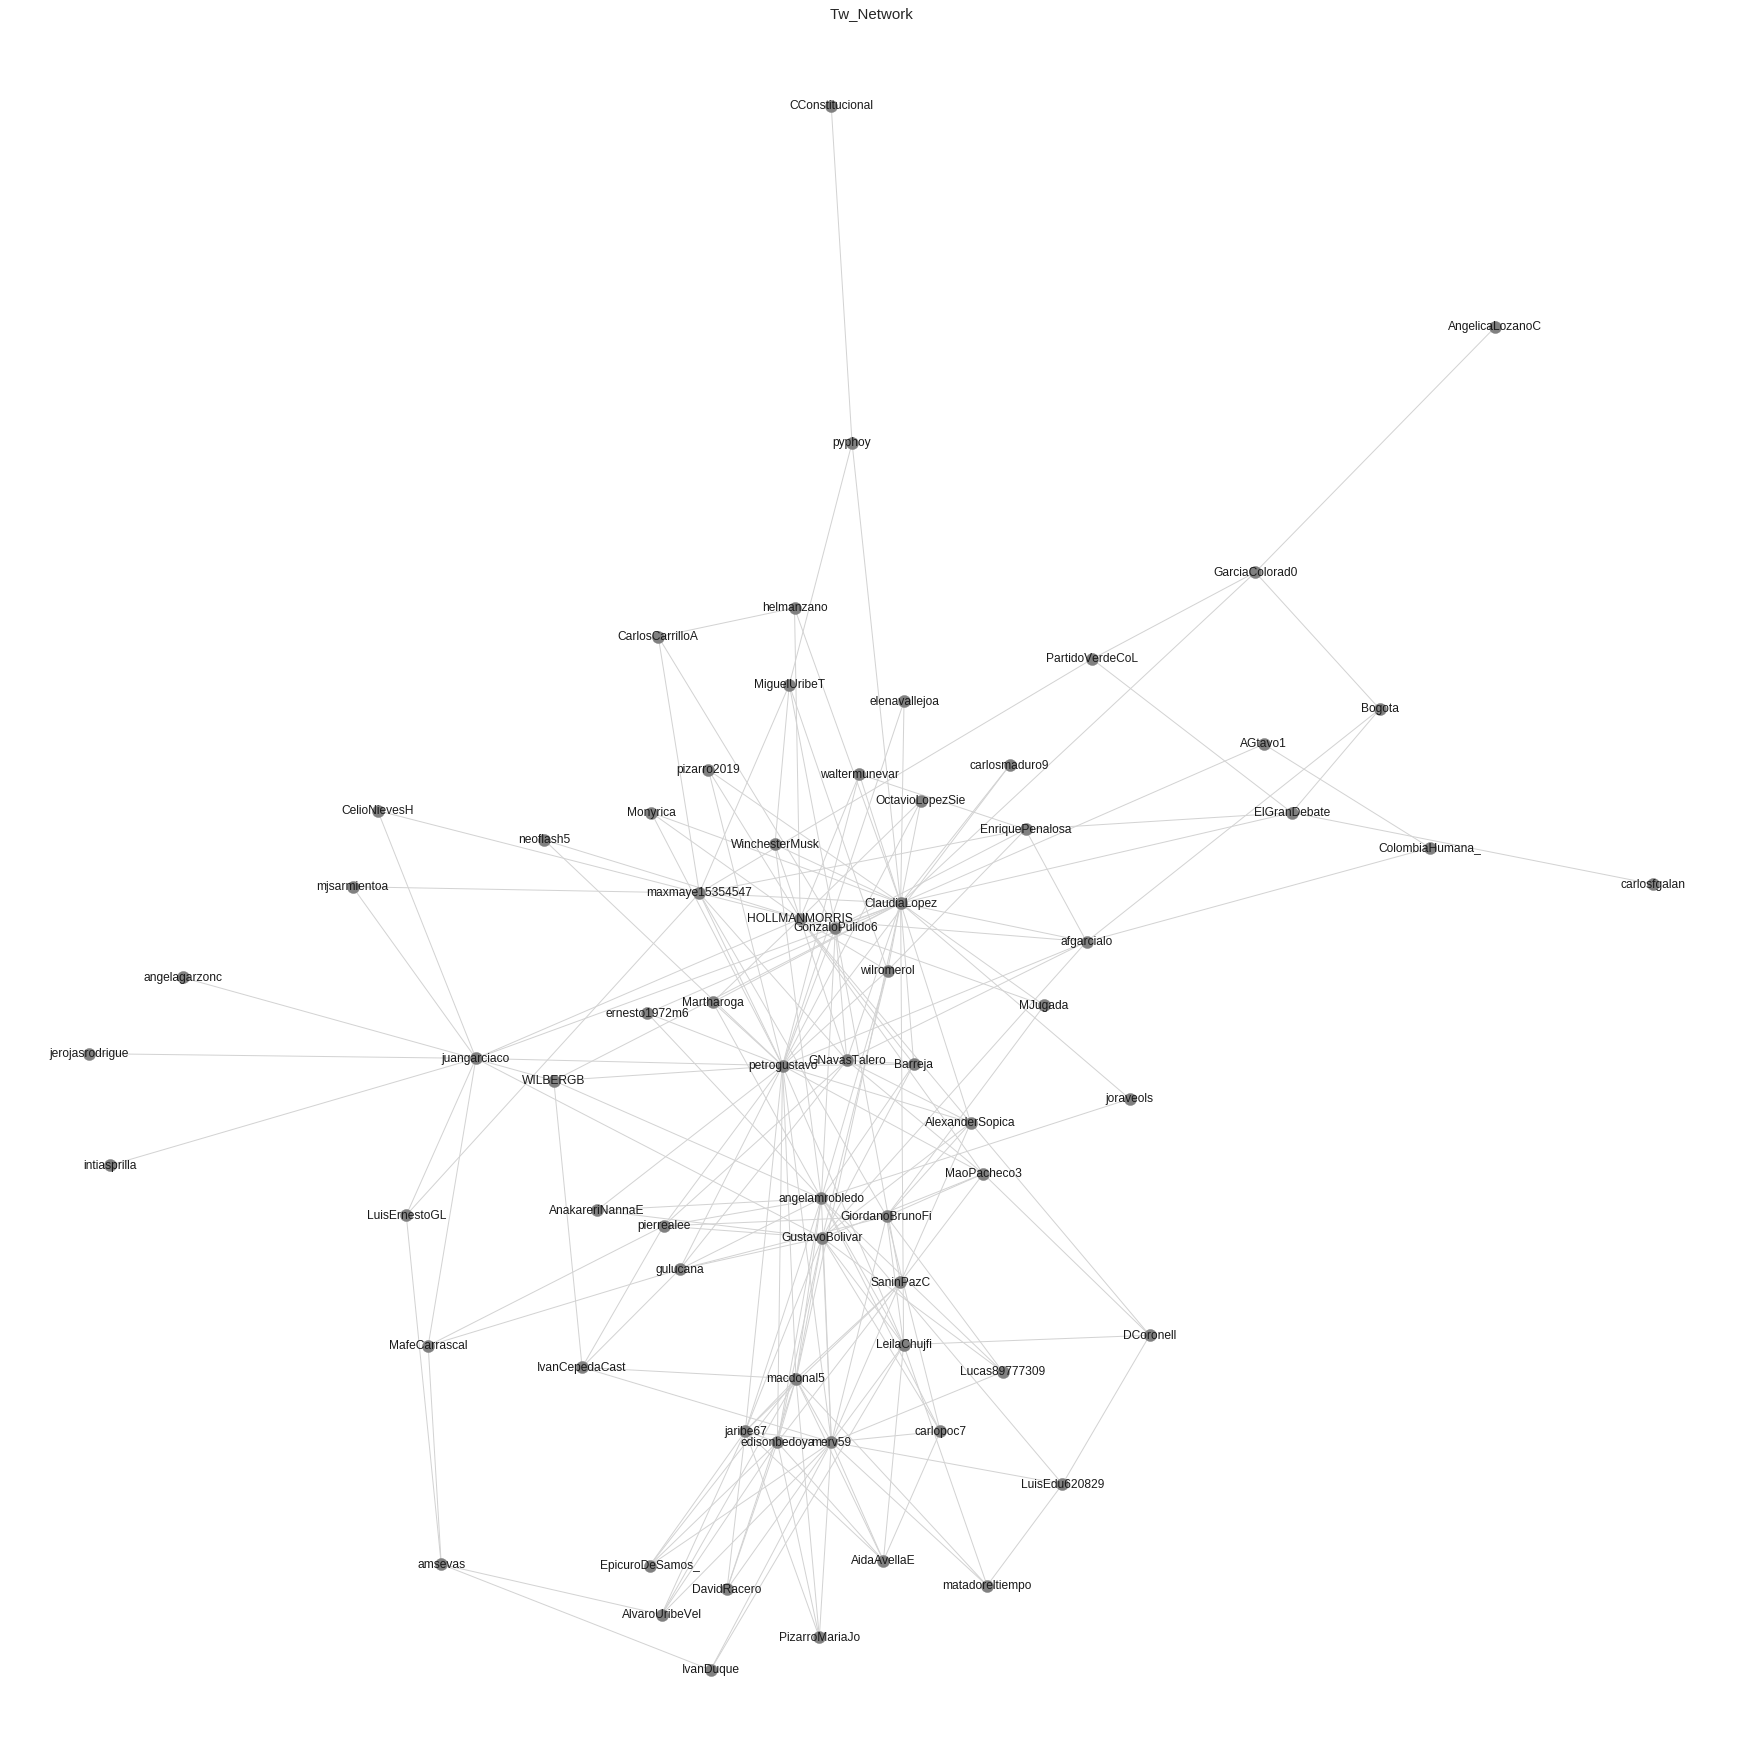

In [191]:
plt.figure(figsize=(24, 24))
nx.draw(g,
        node_size=150,
        edge_color='lightgray',
        node_color='gray',
        with_labels=True)
plt.title('Tw_Network', size=15)
plt.show()
# plt.savefig('tweets_net.png')